<center><h1 style="font-size:40px;">Project 2<br> GANs
</h1></center>

This project will develop a **Conditional Generative adversarial network (cGAN)**. The GAN model has two parts: Generator and Discriminator. 

The generator tries to fool the discriminator and create realistic images. The discriminator's job is to figure out if the image is real or fake. A GAN network is very suitable when there is no clear pattern or we want to "create" new data samples. A good generator can create new and realistic images from images. Conditional GAN takes additional data and condition the fake data generation process to generate particular type of fake data.

This can according to google crash course summarise as:
* The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator.
* The discriminator learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.

The setup is further visualised below for the generator and discriminator provided from [google crash course](https://developers.google.com/machine-learning/gan/gan_structure):
![GAN](gan_diagram.svg)

Some helpful reading materials: 
1. https://dl.acm.org/doi/abs/10.1145/3422622
2. https://arxiv.org/abs/1411.1784
3. https://arxiv.org/abs/1611.07004

# Task

**TODO:** Implement a cGAN.

**TODO:** Condition the generation process such that given the first few (n) images of the sequence, the GAN will generate the last frame. Follow the instructions on Blackboard.



**TODO:** Select a good metric to evaluate the models performance and argue in presentation why does the metric give a good overview of the performance.

**Question:** Explain in the presentation what you did and why. Present a pipeline of the code. 

--- 

**Note:** The current image resolution is set to 32x32 (i.e. IMAGE_WIDTH and IMAGE_HEIGHT) in config.py. 
This way initial experiements can run faster. Once you implement the inital version of the network, please set the resolution values back to 128x128. Experimental results should be provided for this high resolution images.  





# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
from config import LabConfig
import torchmetrics
import transforms as T
import torch
import torchvision
from utils.plot import GAN
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [3]:
cfg = LabConfig()
cfg.todict()

{'training_img_dir': '../../data/FlyingObjectDataset_10K/training/image',
 'validation_img_dir': '../../data/FlyingObjectDataset_10K/validation/image',
 'testing_img_dir': '../../data/FlyingObjectDataset_10K/testing/image',
 'SEED': 420,
 'GPU': 0,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'TENSORBORD_DIR': 'logs/'}

# Dataset
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at [pytorch docs](https://pytorch.org/vision/stable/transforms.html)

The dataset consist of images defined as real data (first n frames and last frame). The fake last frames are created with the generator. For training we can use 50%/50% of real and fake images to train the discriminator. Feel free to experiment what type of input to use for the generator to create a fake image. You can choose to modify or extend FlyingObject or FutureFramePredictorDataset. Or you can make your own dataset class. Here is a template for dataset.

```
class CGAN_Dataset(FlyingObjectDataset):
    def __init__(self, root, transform=None):
        super(CGAN_Dataset, self).__init__(root, transform)
        self.first_frames, self.last_frames = self.get_first_last_frames()
        
    def get_first_last_frames(self):
        # implement your change here
        return NotImplemented
    
    def __getitem__(self, index):
        first = # read first frame 
        last = # read last frame 
        # transform the images 
        #return them as pair 
        return first, last 
       
    def __len__(self):
        return len(self.first_framse)
```

## Augmentation
To ensure that each image have the same shape we pad the dataset. It is possible to resize the images but then the bounding boxes also have to be transformed to correct shape which is not covered in this project! 

In [4]:
train_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_transform_grayscale = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.Grayscale(),
        transforms.Normalize((0.5,), (0.5,))
    ])


## Dataloader

In [6]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    CGAN_Dataset(
        root=cfg.training_img_dir,
        transform=train_transform
    ), 
    batch_size=cfg.BATCH_SIZE,
    shuffle=True, 
    num_workers=0
)

# Create the dataloader
dataloader_grayscale = torch.utils.data.DataLoader(
    dset.ImageFolder(
        root=cfg.training_img_dir,
        transform=train_transform_grayscale
    ), 
    batch_size=cfg.BATCH_SIZE,
    shuffle=True, 
    num_workers=0
)

## Visualise data
To get an idea of the dataset we will first plot the data. This is very important, especially if we perform data augmentation. If the implementation is wrong an qualitative estimation will with a great probability tell if something is wrong.

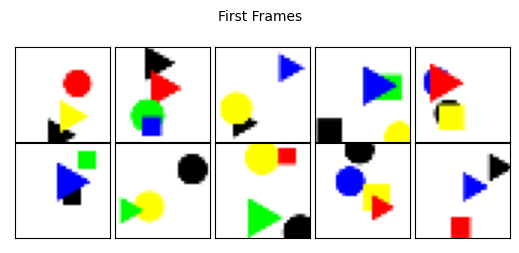

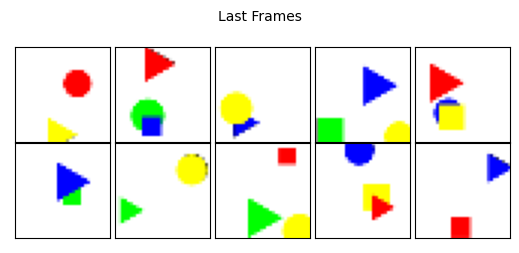

In [8]:
t_x, t_y = next(iter(dataloader))
GAN.frame_data(t_x, t_y)

# Implementation

---
You are free to choose any other generative approach. The generator will take the frist n frames as input and produce an output of the same shape as input. This output will be the generated or fake last frame. The discriminator is a simple classifier that will classify the given data as real or fake.